In [367]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
%matplotlib inline

In [368]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal'] * 100
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'),
 (8421, 39))

In [369]:
data[data['goal'] < 5]['success_rate'].mean()

331540.3557309402

<AxesSubplot:>

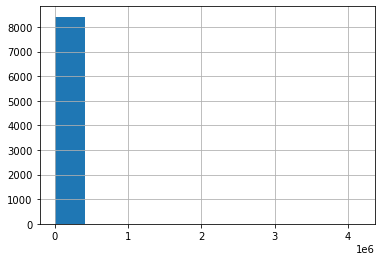

In [370]:
data['success_rate'].hist(bins=10)

In [371]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df.shape

(8421, 37)

In [372]:
df.isnull().sum()

URL                0
pled               0
goal               0
date               0
period             0
status             0
text_am            0
n_img              0
n_vid              0
n_pled_t           0
min_pled_t         0
max_pled_t         0
mean_pled_t        0
step_pled_t        0
cr_time            0
backed             0
created            0
site            2471
rpg                0
platformer         0
shooter            0
fighting           0
survival           0
horror             0
strategy           0
arcade             0
simulator          0
mmo                0
indie              0
action             0
quest              0
adventure          0
mgp                0
cont               0
curr               0
is_site            0
success_rate       0
dtype: int64

In [373]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
futures = ['text_am', 'n_img', 'n_vid', 'cont', 'mgp', 'n_pled_t']
target_column = 'success_rate'
numeric_columns, target_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [374]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(2):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]]) 

In [375]:
def draw_hist(df, features, var_labels, bar_type=None, n_bins=10):
    bar_type = 'bar' if bar_type == None else bar_type
    for col in features:
        plt.figure(figsize=(14, 10))
        plt.hist(df[col], histtype=bar_type, bins=n_bins, color='#BF2D00')
        plt.xlabel(var_labels[col], size=20)
        plt.ylabel(f'Количество проектов', size=20)

In [376]:
def draw_scatter(df, col):
    plt.figure(figsize=(14, 10))
    plt.scatter(df.sort_values(by=[col])[col], df.sort_values(by=[col])['success_rate'], c='#BF2D00')
    plt.xlabel(f'Значение переменной {col}, в ед.', fontsize=20)
    plt.ylabel(f'Значение success_rate, в %.', fontsize=20)

In [461]:
def del_n_sigmas_emissions(df, col_names, n_sigmas=3) -> DataFrame:
    len_was = df.shape[0]
    sigmas = []
    means = []
    for col_name in col_names:
        sigmas.append(df[col_name].std())
        means.append(df[col_name].mean())
    
    for col_name, mean, std in zip(col_names, means, sigmas):
        df = df[(df[col_name] >= mean - std * n_sigmas) & (df[col_name] <= mean + std * n_sigmas)]
        print(f'{col_name}: {len_was - df.shape[0]} lines deleted')
        len_was = df.shape[0]
    return df    

<BarContainer object of 14 artists>

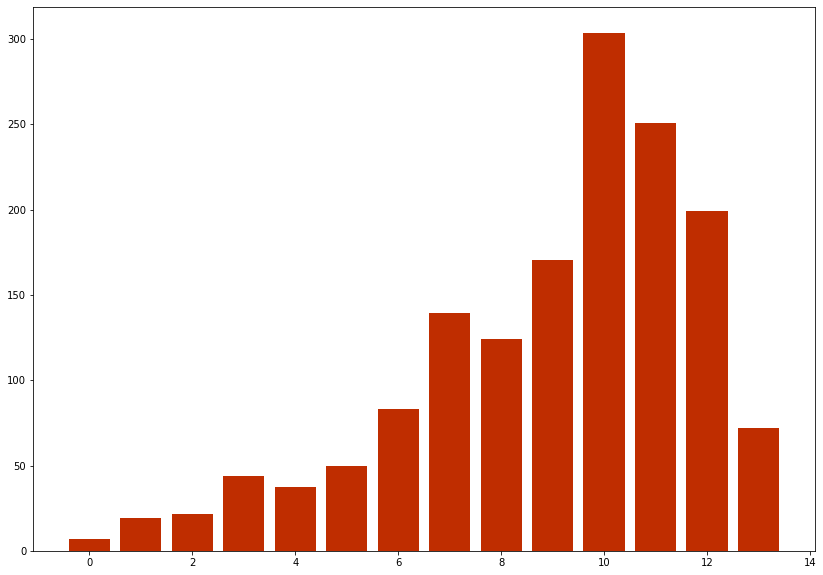

In [462]:
df = pd.read_csv("kickstarter_data.csv")
df['success_rate'] = data['pled'] / data['goal'] * 100


xs, ys = [], []
# Remove emissions
for val in df['created'].unique():
    vars_ = df[df['created'] == val]
    xs.append(val)
    ys.append(vars_['success_rate'].median())


plt.figure(figsize=(14, 10))
plt.bar(xs, ys, color='#BF2D00')

In [463]:
def get_prerocessed_data():
    df = pd.read_csv("kickstarter_data.csv")
    df['success_rate'] = data['pled'] / data['goal'] * 100
    
    # Remove emissions
    df['site'].fillna('', inplace=True)

    print(f'Shape was: {df.shape[0]}')
    # Using 3 sigmas rule
    len_was = df.shape[0]
    df = df[df['goal'] > 15]
    print('goal < 15:', len_was - df.shape[0])
    df = del_n_sigmas_emissions(df, ['success_rate', 'created', 'mgp', 'n_img', 'text_am', 'period', 'goal', 'n_pled_t'])
    
    return df 

df = get_prerocessed_data()
df.shape

Shape was: 8421
goal < 15: 27
success_rate: 93 lines deleted
created: 171 lines deleted
mgp: 132 lines deleted
n_img: 61 lines deleted
text_am: 115 lines deleted
period: 42 lines deleted
goal: 50 lines deleted
n_pled_t: 61 lines deleted


(7669, 39)

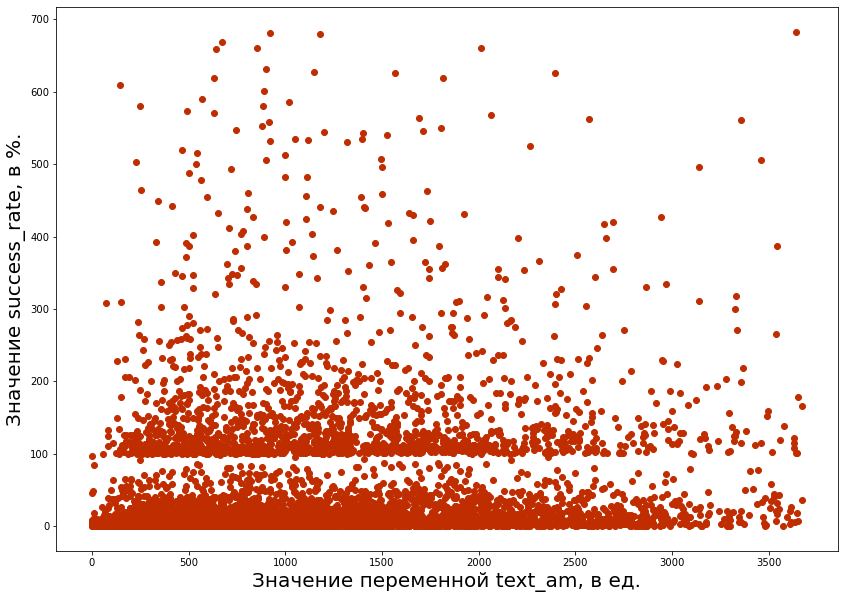

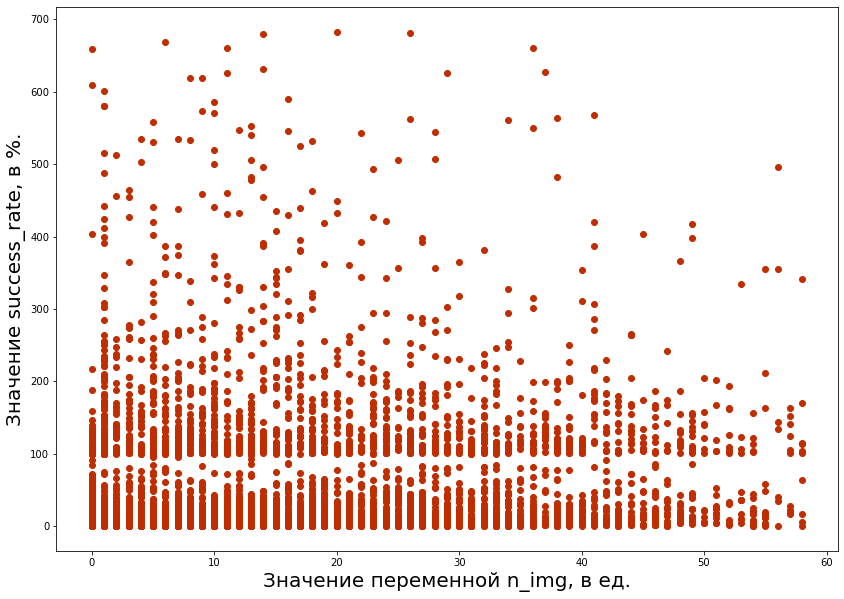

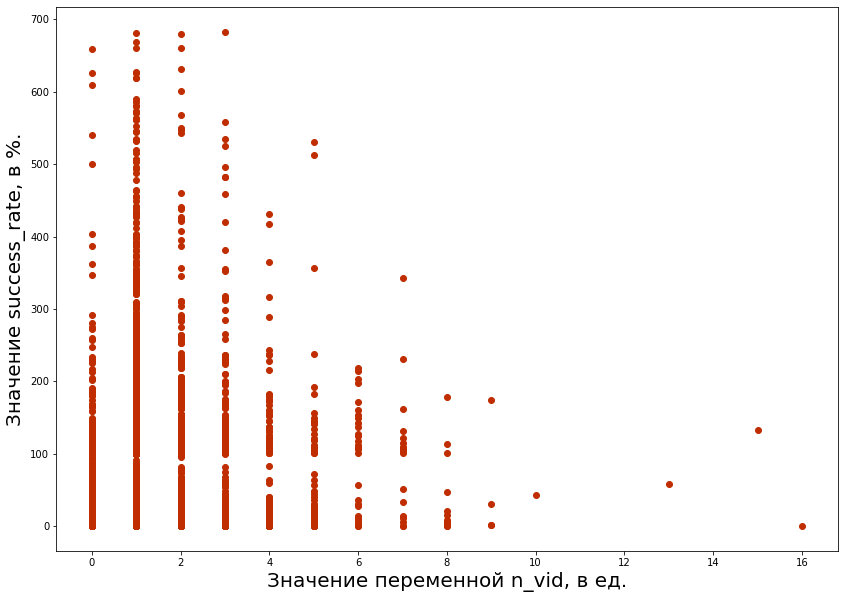

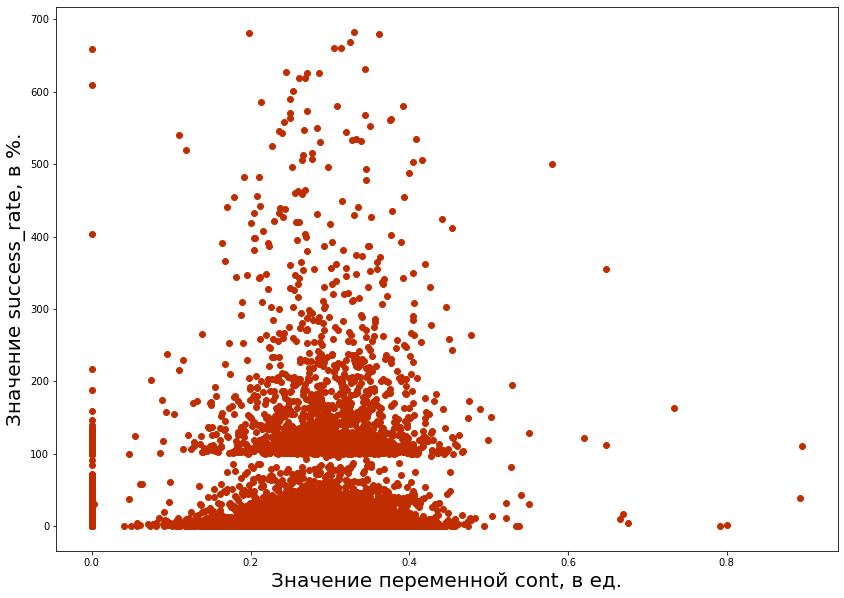

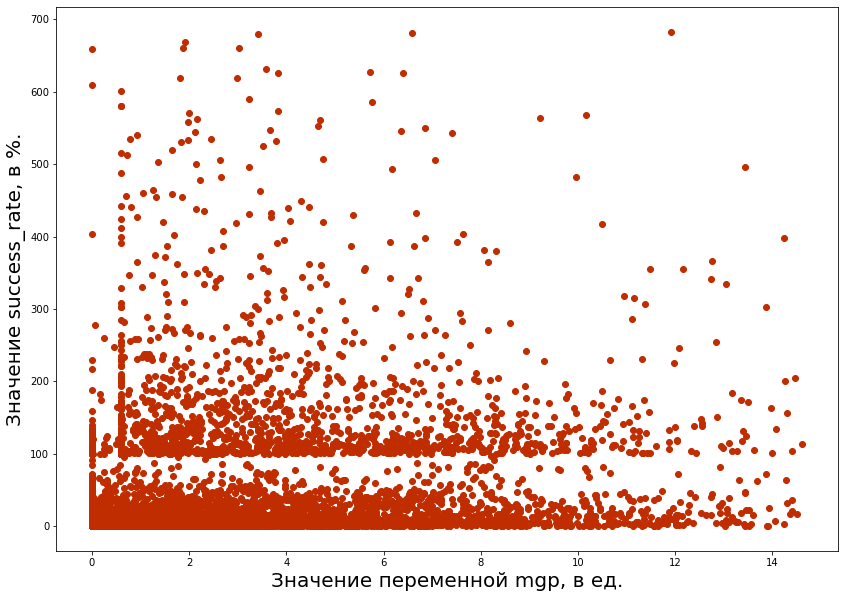

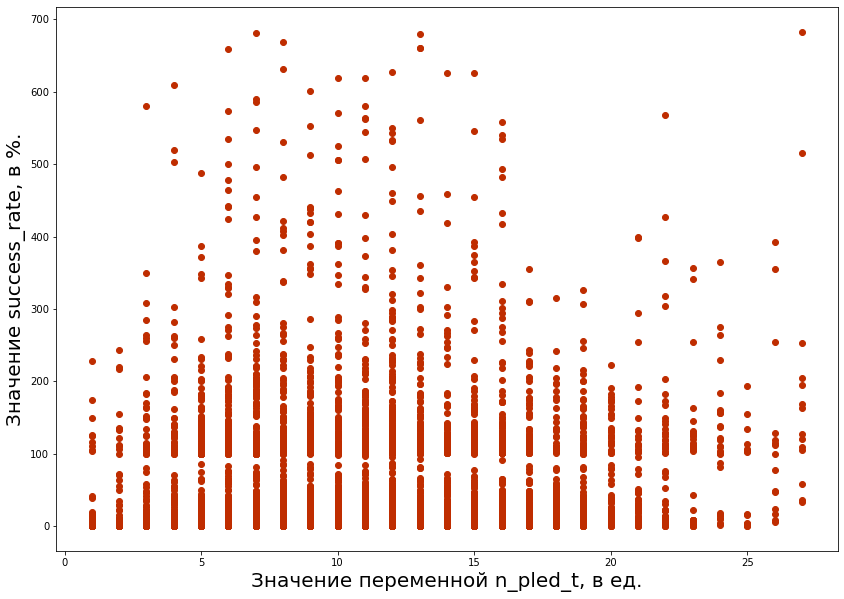

In [380]:
for col in futures:
    draw_scatter(df, col)

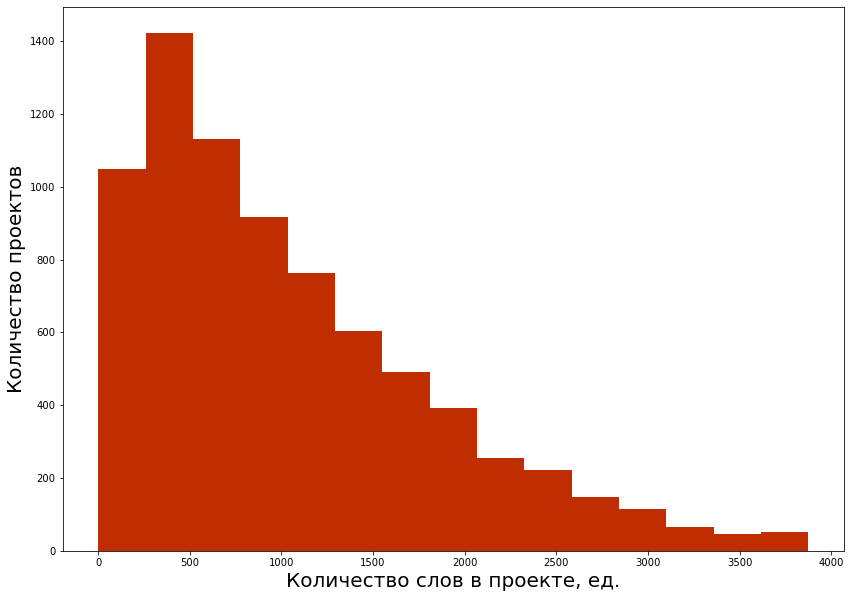

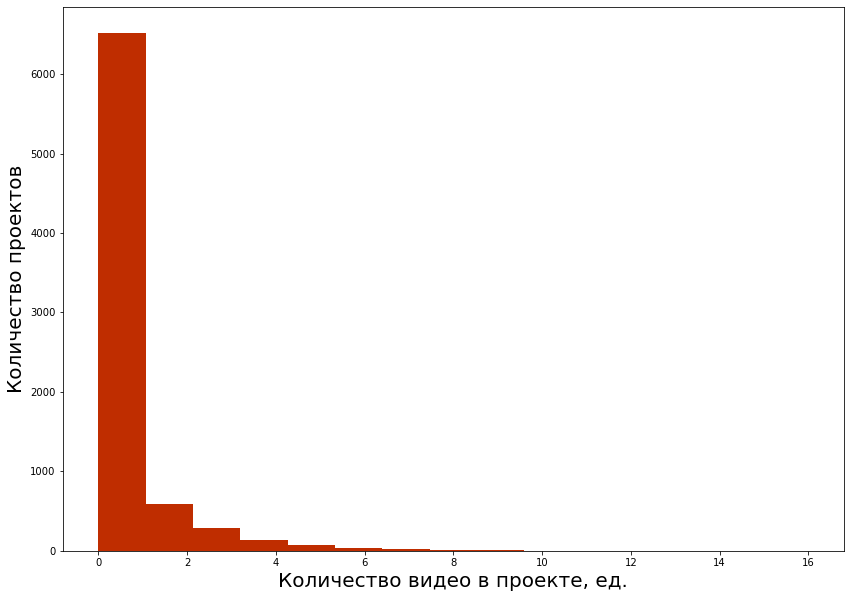

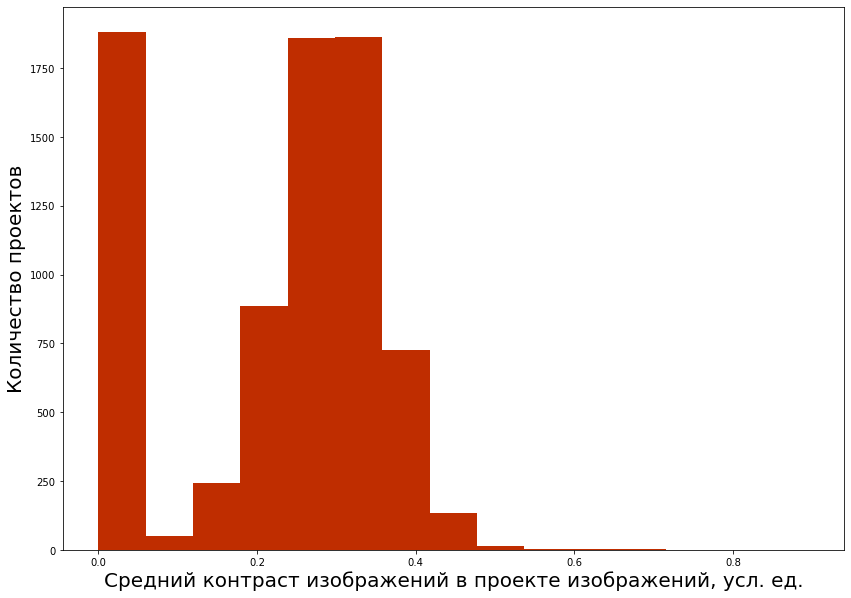

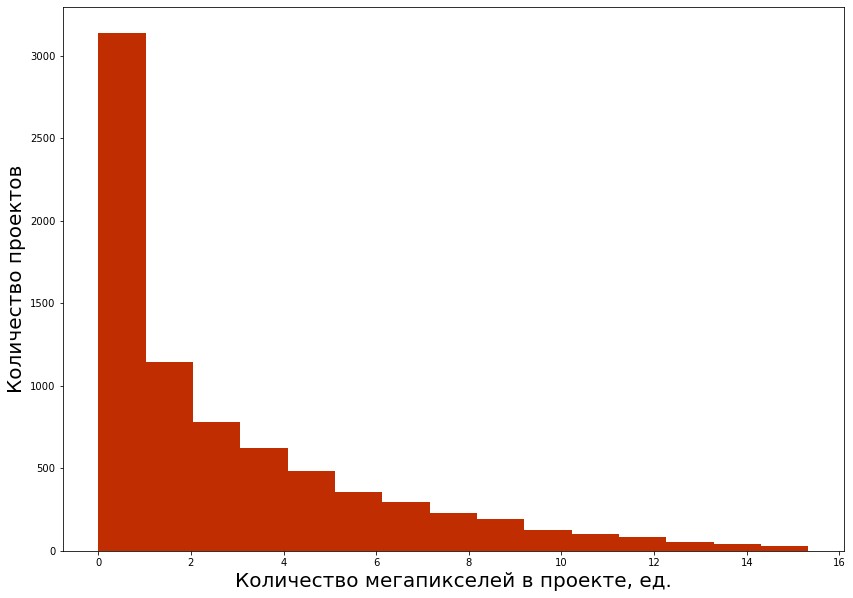

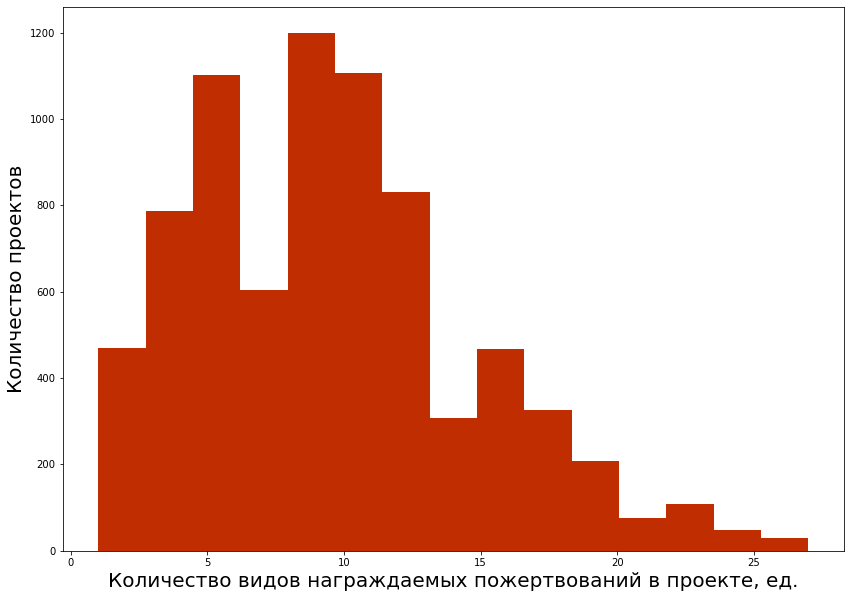

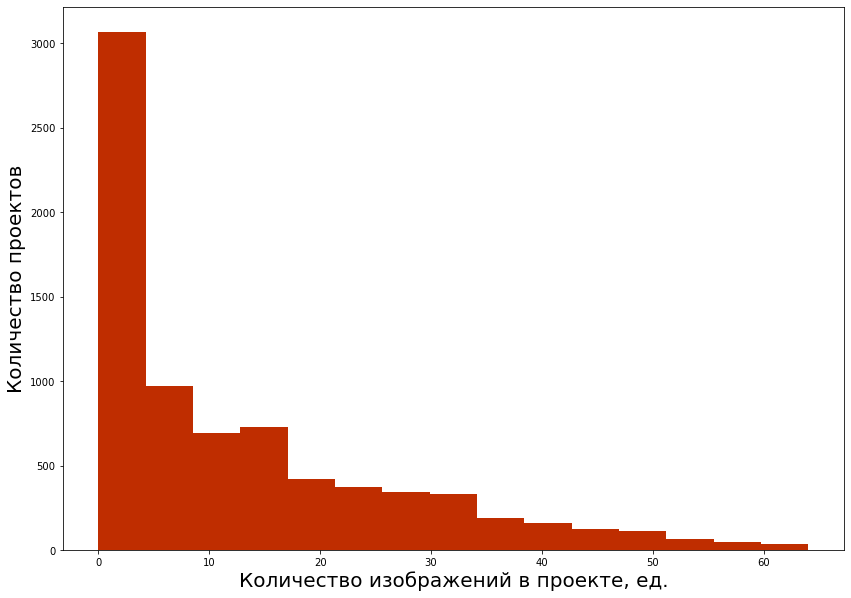

In [464]:
draw_hist(df, futures + ['n_img'], {
    'n_img': 'Количество изображений в проекте, ед.',
    'n_vid': 'Количество видео в проекте, ед.',
    'n_pled_t': 'Количество видов награждаемых пожертвований в проекте, ед.',
    'cont': 'Средний контраст изображений в проекте изображений, усл. ед.',
    'mgp': 'Количество мегапикселей в проекте, ед.',
    'text_am': 'Количество слов в проекте, ед.',
    'period': 'Длительность периода сбора средств, дн.'}, n_bins=15)

In [466]:
# Descriptive statistics
desc = df[futures].describe()
desc.loc[:'count'] = desc.loc[:'count'].astype(np.int64)
desc.append(pd.Series(df[futures].median(), index=futures, name='median'))
desc

,text_am,n_vid,cont,mgp,n_pled_t
count,7669.000000,7669.000000,7669.000000,7669.000000,7669.000000
mean,1040.500717,0.675055,0.221198,2.754572,9.536185
std,793.508616,1.207925,0.139756,3.182465,5.134437
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,404.000000,0.000000,0.110072,0.080040,6.000000
50%,834.000000,0.000000,0.266724,1.617920,9.000000
75%,1486.000000,1.000000,0.321705,4.223644,13.000000
max,3875.000000,16.000000,0.894847,15.330036,27.000000


In [467]:

desc = df[futures + ['success_rate', 'n_img', 'goal', 'period']].describe()
desc.append(pd.Series(df[desc.columns].median(), index=desc.columns, name='median'))
for col in desc.columns:
    series = desc[col]
    idx = series.index
    new_s = []
    for i in idx:
        if float(series[i]).is_integer():
            new_s.append(int(series[i]))
        else:
            new_s.append((f'{series[i]:.2f}'))
    desc[col] = pd.Series(new_s, index=idx)
desc.iloc[1:]

,text_am,n_vid,cont,mgp,n_pled_t,success_rate,n_img,goal,period
mean,1040.50,0.68,0.22,2.75,9.54,44.63,12.65,38869.94,33.50
std,793.51,1.21,0.14,3.18,5.13,83.21,14.16,88328.45,10.14
min,0,0,0,0,1,0,0,18.64,2
25%,404,0,0.11,0.08,6,0.75,1,3500,30
50%,834,0,0.27,1.62,9,6.86,8,10000,30
75%,1486,1,0.32,4.22,13,45.46,20,34094.78,33
max,3875,16,0.89,15.33,27,705,64,856295,66


In [468]:
def draw_dependencies(df, features):
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(36, 18))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            col = features[cols * i + j]
            xs = []
            ys = []

            if col == 'text_am':
                n_texts = []
                step = 200
                for v in range(1, df['text_am'].max(), step):
                    s = df[(df['text_am'] >= v) & (df['text_am'] < v + step)]['success_rate']
                    if s.shape[0] > 5: 
                        n_texts.append((f'{int((2 * v + step) / 2)}', v, s.sum() / s.shape[0]))

                n_texts = sorted(n_texts, key=lambda x: x[1])

                xs = [k for title, k, v in n_texts]
                ys = [v for title, k, v in n_texts]
            elif col == 'cont':
                n_conts = []
                step = 0.05
                for v in np.arange(0, df['cont'].max(), step):
                    s = df[(df['cont'] >= v) & (df['cont'] < v + step)]['cont']
                    if s.shape[0] > 2: 
                        n_conts.append((f'{(2 * v + step) / 2}', v, s.sum() / s.shape[0]))

                n_conts = sorted(n_conts, key=lambda x: x[1])

                xs = [k for title, k, v in n_conts]
                ys = [v for title, k, v in n_conts]
            else:
                for val in sorted(df[col].unique()):
                    mean_sr = df[df[col] == val]['success_rate'].mean()
                    if df[df[col] == val].shape[0] > 5:
                        xs.append(val)
                        ys.append(mean_sr)

            axes[i, j].plot(xs, ys)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Значение переменной success_rate', size=14)

In [469]:
def split_array_by_parts(array_len, n_splits):
    """
    Returns indices for split parts
    """
    step = 0
    if array_len % n_splits == 0:
        step = array_len // n_splits
    else:
        step = array_len // n_splits + 1
    i = 0
    result = []
    while i < array_len:
        result.append((i, min(i + step, array_len)))
        i += step
    return result


def draw_dep(df, cols, n_intervals, var_labels):
    step = 1.0 / n_intervals
    
    indices = split_array_by_parts(df.shape[0], n_intervals)
    
    for col in cols:
        plt.figure(figsize=(14, 10))
        plot_vals = {}
        repeats = {}
        xs = []
        ys = []

        sorted_df = df.sort_values(by=[col])
        for start, stop in indices:
            cur_vals = sorted_df.iloc[start : stop]
            col_median = cur_vals[col].median()
            s_r_mean = cur_vals['success_rate'].mean()
            
            if col == 'cont':
                col_median = cur_vals[col].mean()

            xs.append(col_median)
            ys.append(s_r_mean)
        new_xs, new_ys = [], []
        reps = {}
        vals = {}
        for x, y in zip(xs, ys):
            if x not in reps:
                reps[x] = 0
                vals[x] = []
            reps[x] += 1
            vals[x].append(y)
        for x, n_reps in reps.items():
            new_ys.append(sum(vals[x]) / n_reps)
            es = 0
            if col == 'text_am':
                x /= 100
            new_xs.append(float(f'{x:.2f}'))
            
            
        bar_width = 0.2 if col == 'cont' else 0.8
        plt.bar(new_xs, new_ys, color='#BF2D00', width=bar_width)
        left, right = plt.xlim()
        
        plt.xlim(0, right)
        plt.xlabel(var_labels[col], fontsize=20)
        plt.ylabel(f'Среднее отношение собраных средств к цели, в %.', fontsize=20)            

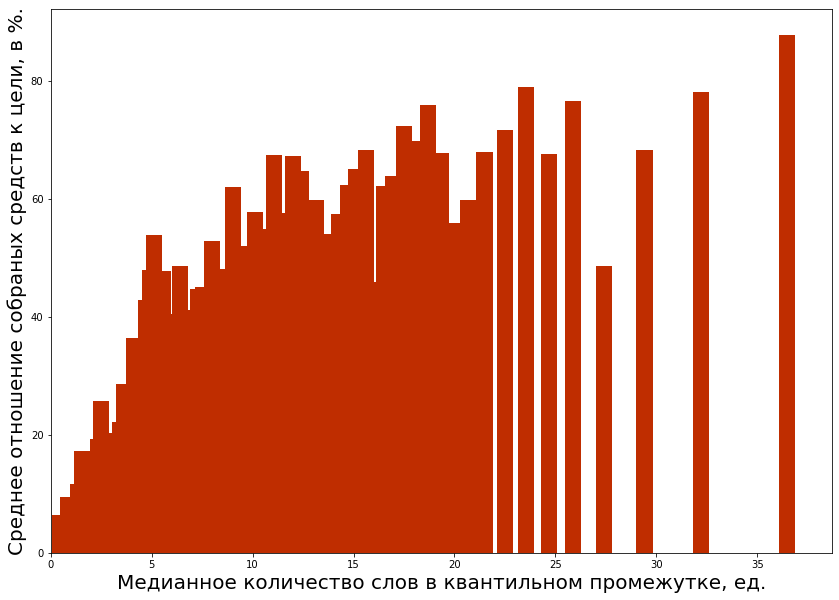

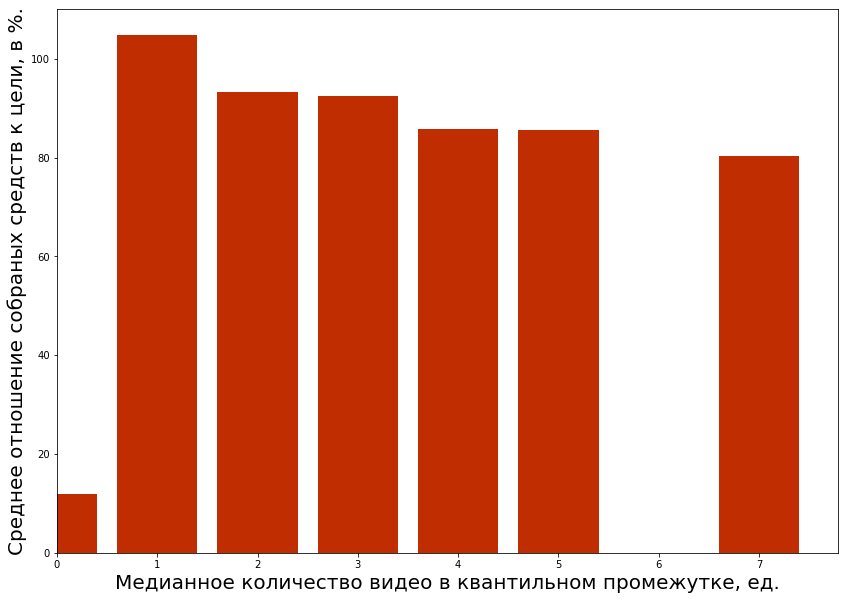

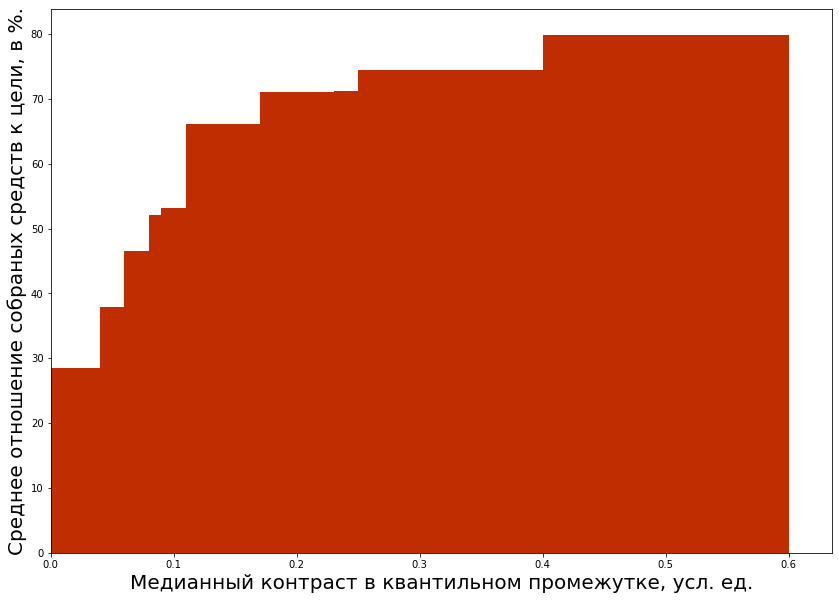

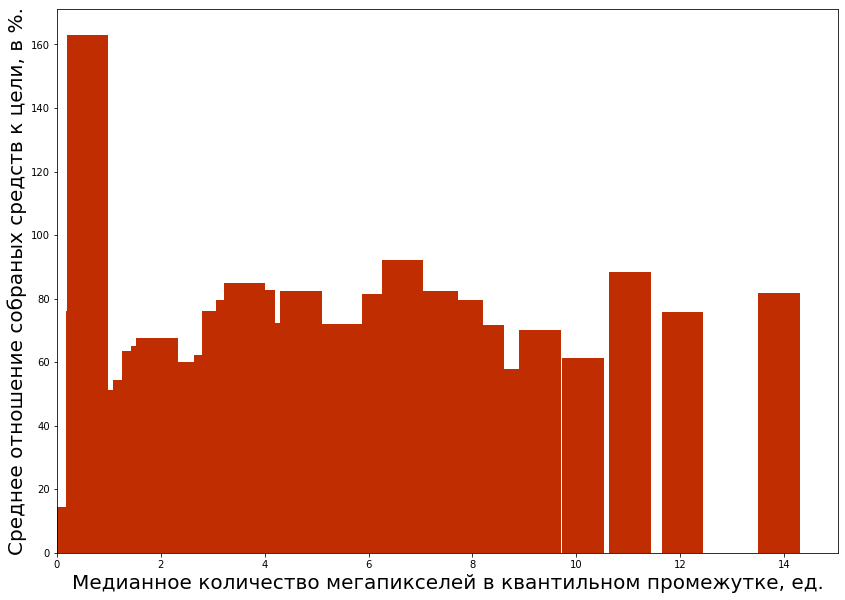

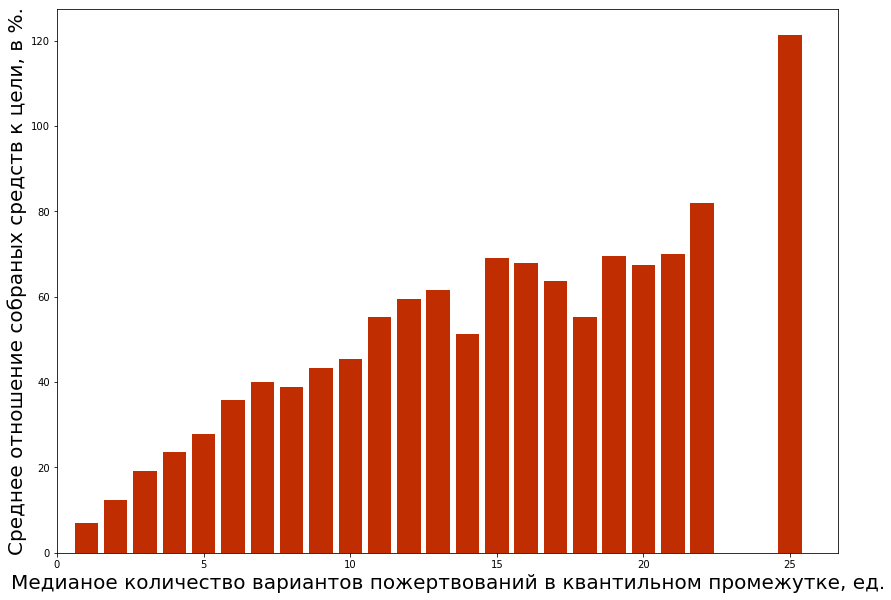

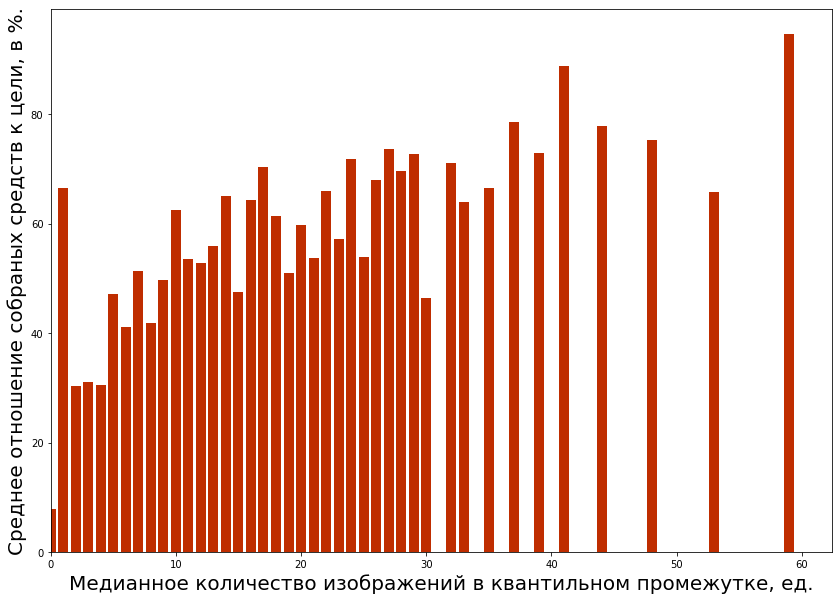

In [754]:
# draw_dependencies(df, futures)
draw_dep(df, futures + ['n_img'], 80,
        {'n_img': 'Медианное количество изображений в квантильном промежутке, ед.',
         'n_vid': 'Медианное количество видео в квантильном промежутке, ед.',
         'mgp': 'Медианное количество мегапикселей в квантильном промежутке, ед.',
         'cont': 'Медианный контраст в квантильном промежутке, усл. ед.',
         'n_pled_t': 'Медианое количество вариантов пожертвований в квантильном промежутке, ед.',
         'text_am': 'Медианное количество слов в квантильном промежутке, ед.'})

(8421, 39)


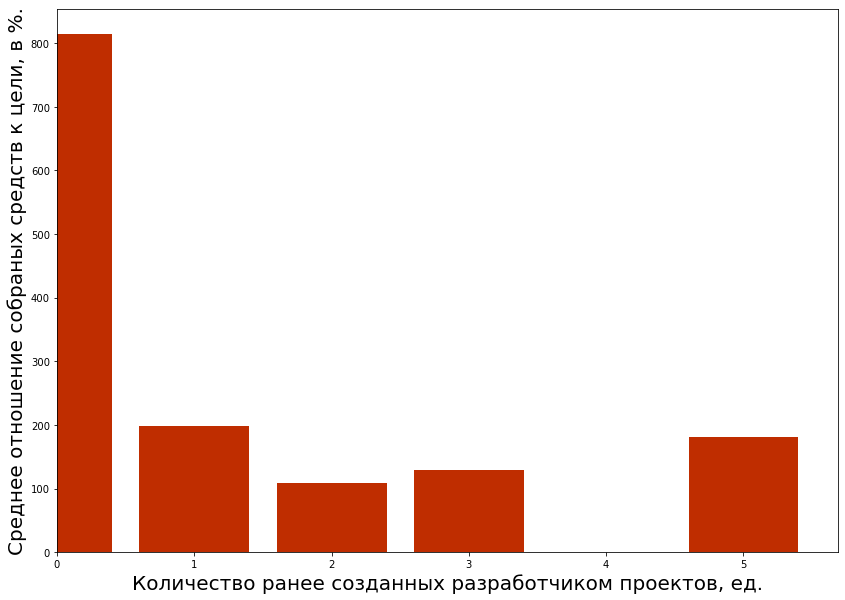

In [471]:
print(data.shape)
draw_dep(data, ['created'], 60, {'created': 'Количество ранее созданных разработчиком проектов, ед.'})

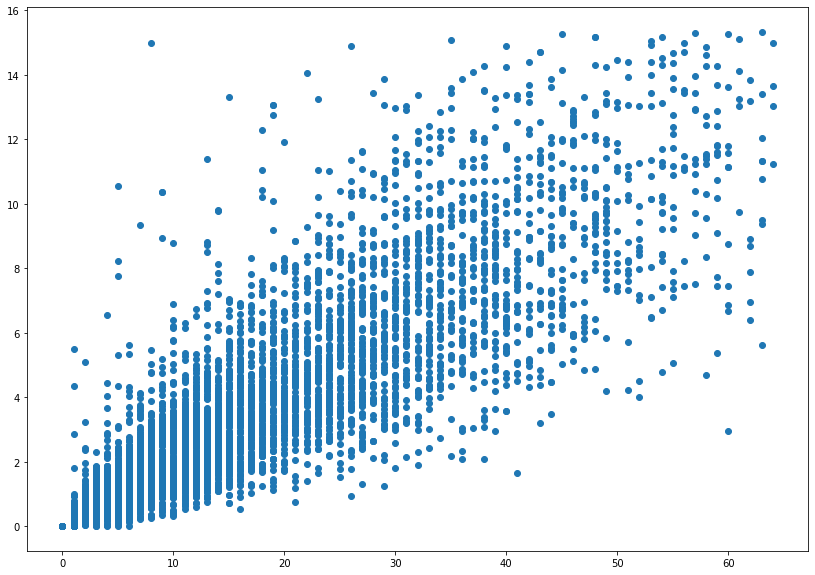

In [472]:
plt.figure(figsize=(14, 10))
plt.scatter(df['n_img'], df['mgp'])

In [685]:
# Linear models
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np

In [825]:
numeric_columns = [
#   'pled', # Linear dependence
#   'goal', # Linear dependence
  'period',
  'text_am',
#   'n_img', # VIF
  'n_vid',
  'n_pled_t',
#   'min_pled_t', # P-val
#   'max_pled_t', # VIF
#   'mean_pled_t', # VIF
  'step_pled_t', # P-val
#   'cr_time', # p-val
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = [
#   'rpg',
#   'platformer', # p-val
#   'shooter',
#   'fighting', # p-val
#   'survival', # p-val
#   'horror',
#   'strategy',
#   'arcade', # p-val
#   'simulator', # p-val
#   'mmo',
#   'indie',
#   'action',
#   'quest', # p-val
#   'adventure', # p-val
  'is_site']
futures = ['text_am', 'n_vid', 'cont',
           'mgp', # 'n_img',
           'n_pled_t']
columns = numeric_columns # + binary_columns

In [826]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif = pd.DataFrame()
vif_data = pd.DataFrame()
vif_data["feature"] = df[columns].columns
vif_data["VIF"] = [variance_inflation_factor(df[columns].values, i)
                          for i in range(len(df[columns].columns))]
vif_data

,feature,VIF
0,period,3.949930
1,text_am,5.080196
2,n_vid,1.594185
3,n_pled_t,7.399162
4,step_pled_t,1.459462
5,backed,1.194565
6,created,1.172802
7,mgp,3.276853
8,cont,4.154251


In [827]:
df = get_prerocessed_data()
idx = 3
inp = df[columns].assign(bias=np.ones((df.shape[0])))
squared_columns = [['text_am'], ['cont', 'mgp'], ['n_vid'], ['n_vid','mgp', 'text_am']]


for col in squared_columns[idx]:
    inp[f'{col}_sqr'] = inp[col] ** 2
    square_columns.append(f'{col}_sqr')

ols = sm.OLS(df['success_rate'], inp)
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
res.summary()

Shape was: 8421
goal < 15: 27
success_rate: 93 lines deleted
created: 171 lines deleted
mgp: 132 lines deleted
n_img: 61 lines deleted
text_am: 115 lines deleted
period: 42 lines deleted
goal: 50 lines deleted
n_pled_t: 61 lines deleted


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           success_rate   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     162.8
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:53:37   Log-Likelihood:                -43917.
No. Observations:                7669   AIC:                         8.786e+04
Df Residuals:                    7656   BIC:                         8.795e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
period         -0.2816      0.085     -3.324      0.001      -0.448      -0.116
text_am         0.0019      0.004      0.468      0.639      -0.006       0.010
n_vid          41.5791      1.387     29.987      0.000      38.861      44.297
n_pled_t        0.6783      0.224      3.023      0.003       0.238       1.118
step_pled_t    -0.0148      0.002     -6.558      0.000      -0.019      -0.010
backed          0.3905      0.086      4.536      0.000       0.222       0.559
created        10.4919      1.952      5.376      0.000       6.666      14.318
mgp             2.6100      0.982      2.659      0.008       0.686       4.534
cont           45.8099      7.704      5.946      0.000      30.707      60.912
bias           13.7892      3.809      3.620      0.000       6.322      21.256
n_vid_sqr      -4.4803      0.213    -21.028      0.000      -4.898      -4.063
mgp_sqr        -0.2014      0.078     -2.570      0.010      -0.355      -0.048
text_am_sqr -4.717e-07   1.18e-06     -0.400      0.689   -2.78e-06    1.84e-06
==============================================================================
Omnibus:                     5662.862   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117086.052
Skew:                           3.378   Prob(JB):                         0.00
Kurtosis:                      20.910   Cond. No.                     2.74e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

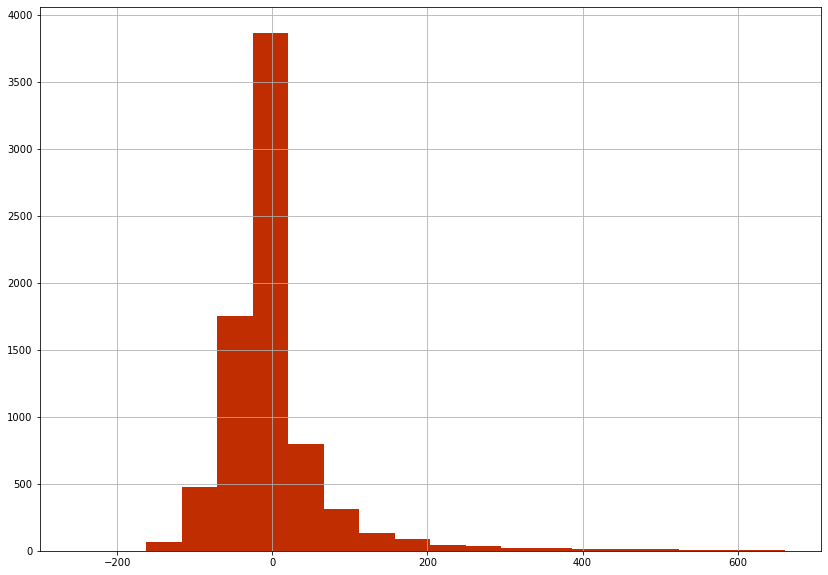

In [828]:
plt.figure(figsize=(14, 10))
res.resid.hist(bins=20, color='#BF2D00')

In [817]:
def draw_lines_on_plot(df, col, coeffs, bias):
    plt.figure(figsize=(14, 10))
    def func(x):
        res = bias
        for i in range(len(coeffs)):
            res += coeffs[i] * x ** (len(coeffs) - i)
        return res
    plt.plot(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), c='red')
    plt.scatter(df.sort_values(by=[col])[col], df.sort_values(by=[col])['success_rate'])

n_vid y=-4.4803x^2 + 41.5791x + 13.7892 Xв=4.640213824967078
mgp y=-0.2014x^2 + 2.61x + 13.7892 Xв=6.479642502482622
text_am y=-4.717e-07x^2 + 0.0019x + 13.7892 Xв=2013.9919440322237


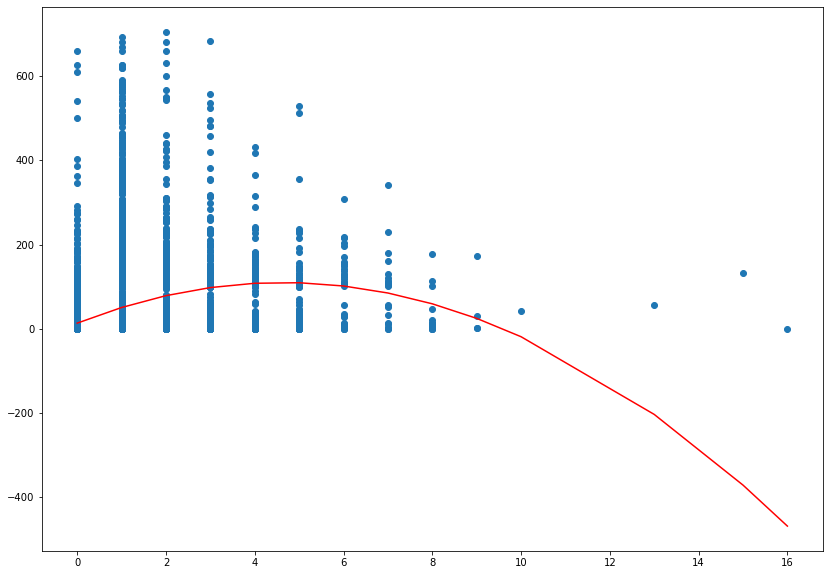

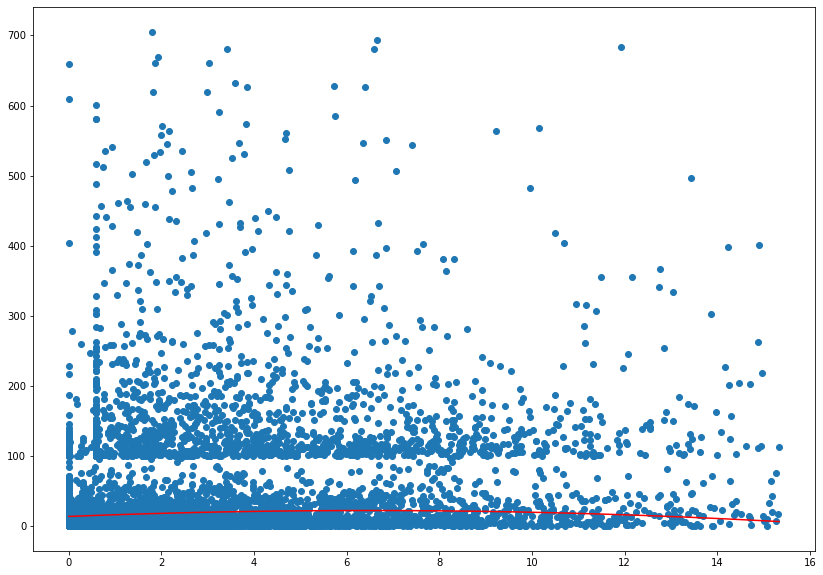

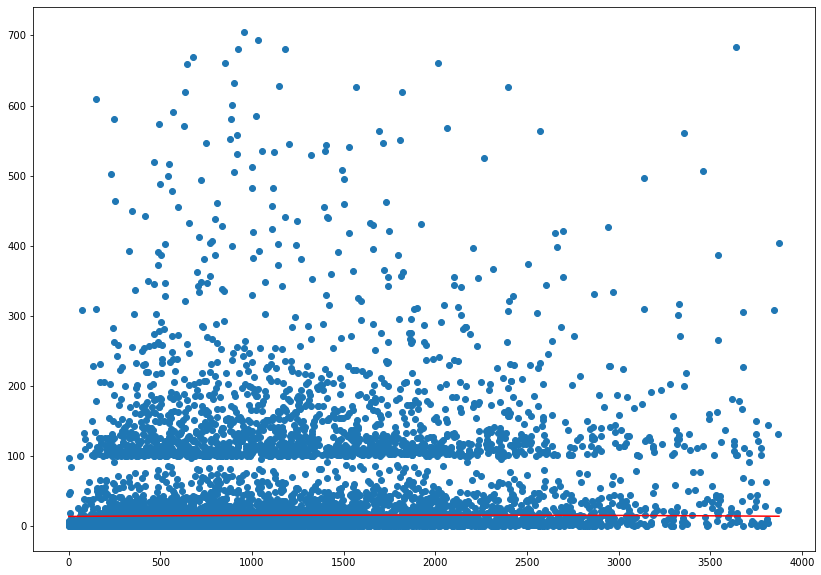

In [818]:
for col in squared_columns[idx]:
    draw_lines_on_plot(inp.assign(success_rate=df['success_rate']),
                       col, [summary_df['coef'][f'{col}_sqr'], summary_df['coef'][col]], summary_df['coef']['bias'])
    a = summary_df["coef"][f"{col}_sqr"]
    b = summary_df["coef"][col]
    c = summary_df["coef"]["bias"]
    print(col, f'y={a}x^2 + {b}x + {c}', f'Xв={-b/(2*a)}')

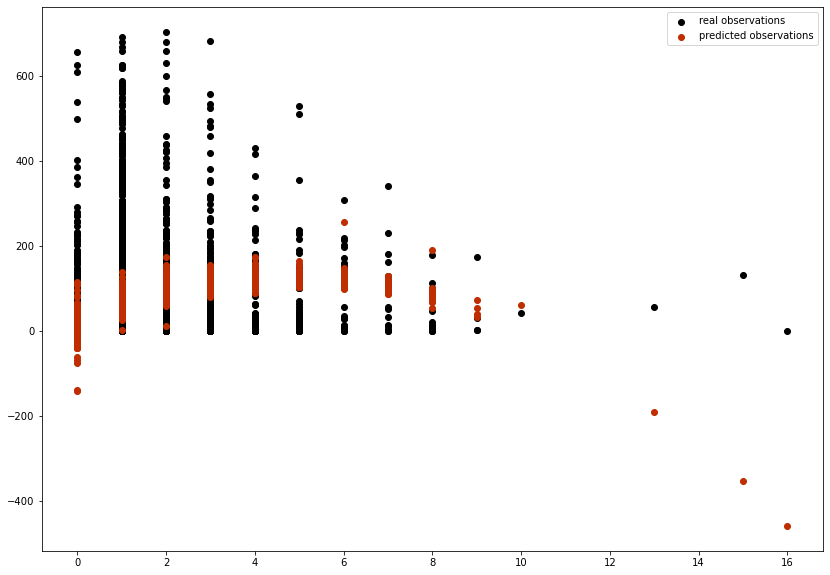

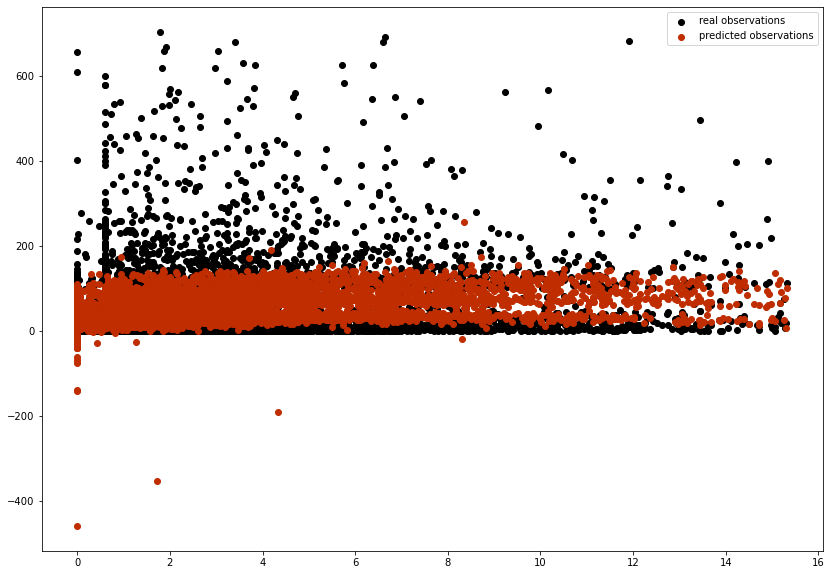

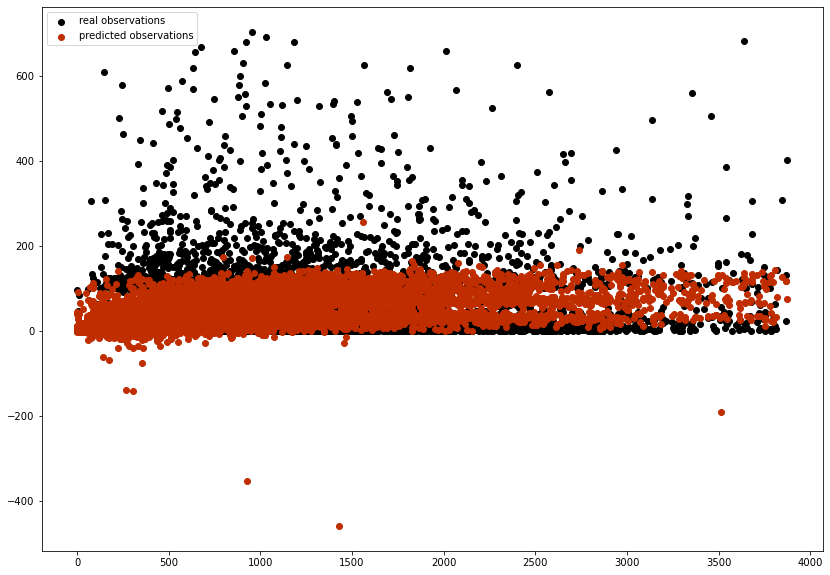

In [819]:
model = LinearRegression(fit_intercept=False)
model.fit(inp, df['success_rate'])
preds = model.predict(inp.to_numpy().reshape(inp.shape[0], inp.shape[1]))
for col in squared_columns[idx]:   
    
    plt.figure(figsize=(14, 10))
    plt.scatter(inp[col], df['success_rate'], label='real observations', color='black')
    plt.scatter(inp[col], preds, label='predicted observations', color='#BF2D00')
    plt.legend()

In [704]:
# Cascade Adj. r^2 check
inp = df[columns]  # .assign(bias=np.ones((df.shape[0])))
ols = sm.OLS(df['success_rate'], inp)
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

r_2_origin = res.rsquared_adj

important_cols = list(summary_df.index)

for col in summary_df.index:
    col_copy = inp[col]
    inp = inp.drop(columns=[col])
    ols = sm.OLS(df['success_rate'], inp)
    res = ols.fit()
    new_r_2 = res.rsquared_adj
    
    if abs(new_r_2 - r_2_origin) / r_2_origin > 0.005:
            inp[col] = col_copy
    else:
        print('removed', col, (new_r_2 - r_2_origin) / r_2_origin)
        important_cols.remove(col)
print(important_cols)

removed period -7.225178249569362e-05
removed text_am -0.0004244253026000687
removed backed -0.0037632442131358434
['n_vid', 'n_pled_t', 'step_pled_t', 'created', 'mgp', 'cont', 'rpg', 'shooter', 'horror', 'strategy', 'mmo', 'indie', 'action', 'is_site']


In [681]:
# Check log reg and log(linear reg)
linear = LinearRegression()
linear.fit(df[columns].assign(bias=np.ones(df.shape[0])), df['success_rate'])
preds1 = linear.predict(df[columns].assign(bias=np.ones(df.shape[0])))

r2_score(df['success_rate'], preds1)

# logreg = LogisticRegression(max_iter=1000)
# df['success'] = df['success_rate'].apply(lambda x: 1 if x >= 1 else 0) 
# logreg.fit(df[columns].assign(bias=np.ones(df.shape[0])), df['success'])
# preds2 = logreg.predict_proba(df[columns].assign(bias=np.ones(df.shape[0])))
# r2_score(df['success_rate'], preds2[:, 1])

0.16941555785735096